# Gravitational-Waves Gliches Detection

### Project for Big Data Computing exam.

In this project, I will address the problem of detecting glitches in gravitational wave detectors. In particular, I will replicate the results of a scientific paper that uses deep learning to classify glitches.


**NOTE : this notebook takes hours of computation. Therefore some part has been commented. Moreover is necessary a BASIC setting in advance.
You have to have a folder called "BigData_project" in your Google drive account and it MUST contains your "kaggle.json" file which enables the API kaggle.**

### 1) Set the environment

In [ ]:
! pip install pyspark

import pyspark
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
sc = SparkContext(conf=conf)

     |████████████████████████████████| 212.4 MB 67 kB/s 
     |████████████████████████████████| 198 kB 38.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=e99f29a1d03835f0c11e57d6f034d25018ad6eecc25da44db31fe994db5d250c
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
# check if all is ok
sc

<SparkContext master=local[8] appName=Elephas_App>

### 2) Download the dataset using Kaggle API

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/BigData_project"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**NOTE : here is MANDATORY to have a folder called "BigData_project" in your google drive linked above, where you have to put the "kaggle.json" file downloaded from your kaggle account. I cannot put mine as it is private !!**

In [ ]:
%cd /content/gdrive/MyDrive/BigData_project/

/content/gdrive/MyDrive/BigData_project


In [ ]:
! kaggle datasets download -d tentotheminus9/gravity-spy-gravitational-waves

In [ ]:
! unzip \*.zip  && rm *.zip

### 3) Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import sklearn.preprocessing as pproc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pyspark
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB1, EfficientNetB0
from tensorflow.keras.models import Model

### 4) Load the datasets via Tensorflow

In [ ]:
train_generator = ImageDataGenerator()
data_train = train_generator.flow_from_directory( "/content/gdrive/MyDrive/BigData_project/train/train/" ,
                                                     batch_size=50, target_size=(300,300), class_mode="categorical")


Found 22348 images belonging to 22 classes.


In [ ]:
validation_generator = ImageDataGenerator()
data_val = validation_generator.flow_from_directory( "/content/gdrive/MyDrive/BigData_project/validation/validation/",
                                                     batch_size=50, target_size=(300,300) )

Found 4800 images belonging to 22 classes.


In [ ]:
test_generator = ImageDataGenerator()
data_test = test_generator.flow_from_directory( "/content/gdrive/MyDrive/BigData_project/test/test/",
                                                     batch_size=50, target_size=(300,300), class_mode="categorical" , shuffle=False)

Found 4720 images belonging to 22 classes.


Let's print some infos about the datasets

In [ ]:
data_train.class_indices

{'1080Lines': 0,
 '1400Ripples': 1,
 'Air_Compressor': 2,
 'Blip': 3,
 'Chirp': 4,
 'Extremely_Loud': 5,
 'Helix': 6,
 'Koi_Fish': 7,
 'Light_Modulation': 8,
 'Low_Frequency_Burst': 9,
 'Low_Frequency_Lines': 10,
 'No_Glitch': 11,
 'None_of_the_Above': 12,
 'Paired_Doves': 13,
 'Power_Line': 14,
 'Repeating_Blips': 15,
 'Scattered_Light': 16,
 'Scratchy': 17,
 'Tomte': 18,
 'Violin_Mode': 19,
 'Wandering_Line': 20,
 'Whistle': 21}

In [ ]:
data_test.class_indices

{'1080Lines': 0,
 '1400Ripples': 1,
 'Air_Compressor': 2,
 'Blip': 3,
 'Chirp': 4,
 'Extremely_Loud': 5,
 'Helix': 6,
 'Koi_Fish': 7,
 'Light_Modulation': 8,
 'Low_Frequency_Burst': 9,
 'Low_Frequency_Lines': 10,
 'No_Glitch': 11,
 'None_of_the_Above': 12,
 'Paired_Doves': 13,
 'Power_Line': 14,
 'Repeating_Blips': 15,
 'Scattered_Light': 16,
 'Scratchy': 17,
 'Tomte': 18,
 'Violin_Mode': 19,
 'Wandering_Line': 20,
 'Whistle': 21}

In [ ]:
data_val.class_indices

{'1080Lines': 0,
 '1400Ripples': 1,
 'Air_Compressor': 2,
 'Blip': 3,
 'Chirp': 4,
 'Extremely_Loud': 5,
 'Helix': 6,
 'Koi_Fish': 7,
 'Light_Modulation': 8,
 'Low_Frequency_Burst': 9,
 'Low_Frequency_Lines': 10,
 'No_Glitch': 11,
 'None_of_the_Above': 12,
 'Paired_Doves': 13,
 'Power_Line': 14,
 'Repeating_Blips': 15,
 'Scattered_Light': 16,
 'Scratchy': 17,
 'Tomte': 18,
 'Violin_Mode': 19,
 'Wandering_Line': 20,
 'Whistle': 21}

Thus we have :

1) 22 classes.

2) 22348 train samples

3) 4800 validation samples

4) 4720 test samples

### 5) Transfer Learning. Load the models.

In [ ]:
def create_model(name):

    if name=='VGG16':
        conv_base = InceptionV3(include_top=False,
                            weights = "imagenet", 
                            input_shape= (300,300,3))
            
        # Defines how many layers to freeze during training.
        # Layers in the convolutional base are switched from trainable to non-trainable
        # depending on the size of the fine-tuning parameter.

        for layer in conv_base.layers[:-2]:
            layer.trainable = False

        # Create a new 'top' of the model (i.e. fully-connected layers).
        # This is 'bootstrapping' a new top_model onto the pretrained layers.
        top_model = conv_base.output
        top_model = layers.Flatten(name="flatten")(top_model)
        top_model = layers.Dense(128, activation='relu')(top_model)
        top_model = layers.Dense(32, activation='relu')(top_model)
        top_model = layers.Dropout(0.4)(top_model)
        output_layer = layers.Dense(22, activation='softmax')(top_model)
            
        # Group the convolutional base and new fully-connected layers into a Model object.
        model = Model(inputs=conv_base.input, outputs=output_layer)

        model.summary()

        return model
   
    if name=='EfficientNetB1':
        conv_base = EfficientNetB1(include_top=False,weights = "imagenet", input_shape= (300,300,3))
            
        # Defines how many layers to freeze during training.
        # Layers in the convolutional base are switched from trainable to non-trainable
        # depending on the size of the fine-tuning parameter.

        for layer in conv_base.layers[:-2]:
            layer.trainable = False

            # Create a new 'top' of the model (i.e. fully-connected layers).
            # This is 'bootstrapping' a new top_model onto the pretrained layers.
        top_model = conv_base.output
        top_model = layers.Flatten(name="flatten")(top_model)
        top_model = layers.Dense(128, activation='relu')(top_model)
        top_model = layers.Dense(32, activation='relu')(top_model)
        top_model = layers.Dropout(0.5)(top_model)
        output_layer = layers.Dense(22, activation='softmax')(top_model)
            
        # Group the convolutional base and new fully-connected layers into a Model object.
        model = Model(inputs=conv_base.input, outputs=output_layer)

        model.summary()

        return model


    if name=='MobileNetV2':
        conv_base = MobileNetV2(include_top=False,
                            weights = "imagenet", 
                            input_shape= (300,300,3))
            
            # Defines how many layers to freeze during training.
            # Layers in the convolutional base are switched from trainable to non-trainable
            # depending on the size of the fine-tuning parameter.

        for layer in conv_base.layers[:-2]:
            layer.trainable = False

            # Create a new 'top' of the model (i.e. fully-connected layers).
            # This is 'bootstrapping' a new top_model onto the pretrained layers.
        top_model = conv_base.output
        top_model = layers.Flatten(name="flatten")(top_model)
        top_model = layers.Dense(128, activation='relu')(top_model)
        top_model = layers.Dense(32, activation='relu')(top_model)
        top_model = layers.Dropout(0.4)(top_model)
        output_layer = layers.Dense(22, activation='softmax')(top_model)
            
        # Group the convolutional base and new fully-connected layers into a Model object.
        model = Model(inputs=conv_base.input, outputs=output_layer)

        model.summary()

        return model



    if name=='EfficientNetB0':
        conv_base = EfficientNetB0(include_top=False,
                            weights = "imagenet", 
                            input_shape= (300,300,3))
            
            # Defines how many layers to freeze during training.
            # Layers in the convolutional base are switched from trainable to non-trainable
            # depending on the size of the fine-tuning parameter.

        for layer in conv_base.layers[:-2]:
            layer.trainable = False

        
        top_model = conv_base.output
        top_model = layers.Flatten(name="flatten")(top_model)
        top_model = layers.Dense(128, activation='relu')(top_model)
        top_model = layers.Dense(32, activation='relu')(top_model)
        top_model = layers.Dropout(0.4)(top_model)
        output_layer = layers.Dense(22, activation='softmax')(top_model)
            
        # Group the convolutional base and new fully-connected layers into a Model object.
        model = Model(inputs=conv_base.input, outputs=output_layer)

        model.summary()

        return model



def load_model(path_model):
    return tf.keras.models.load_model(path)

We can test different models. The possbile choices are : 

1) MobileNetV2 : "MobileNetV2"

2) EfficientNetB0 : "model_EfficientNetB0"

3) EfficientNetB1 : "model_EfficientNetB0"

4) VGG16 : "model_VGG16"

In [ ]:
#create the model

model = create_model("MobileNetV2")

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [ ]:
# compile and train
model.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics = ["accuracy"] )

history = model.fit(data_train, steps_per_epoch=50, epochs=50)

In [ ]:
# plot loss during training

acc = history.history['accuracy']
#acc_val = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='accuracy_train')
#plt.plot(epochs, acc_val, 'g', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

save the model if necessary!

In [ ]:
#model.save("/content/gdrive/MyDrive/BigData_project/EfficientNetB0.pt")

Load the models if they are already saved.

In [ ]:
model = tf.keras.models.load_model("/content/gdrive/MyDrive/BigData_project/EfficientNetB0.pt")
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 300, 300, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 300, 300, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

### 6) Testing

Test the model on the test set.

In [ ]:
scores = model.evaluate(data_test, verbose=1, workers=4 )
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

95/95 [==============================] - 272s 3s/step - loss: 0.3319 - accuracy: 0.9299
Test loss: 0.33193516731262207
Test accuracy: 0.9298728704452515


We need to go deeper.. Let's print the confusion matrix

In [ ]:
Y = model.predict(data_test, workers=4, verbose=1, )

95/95 [==============================] - 46s 452ms/step


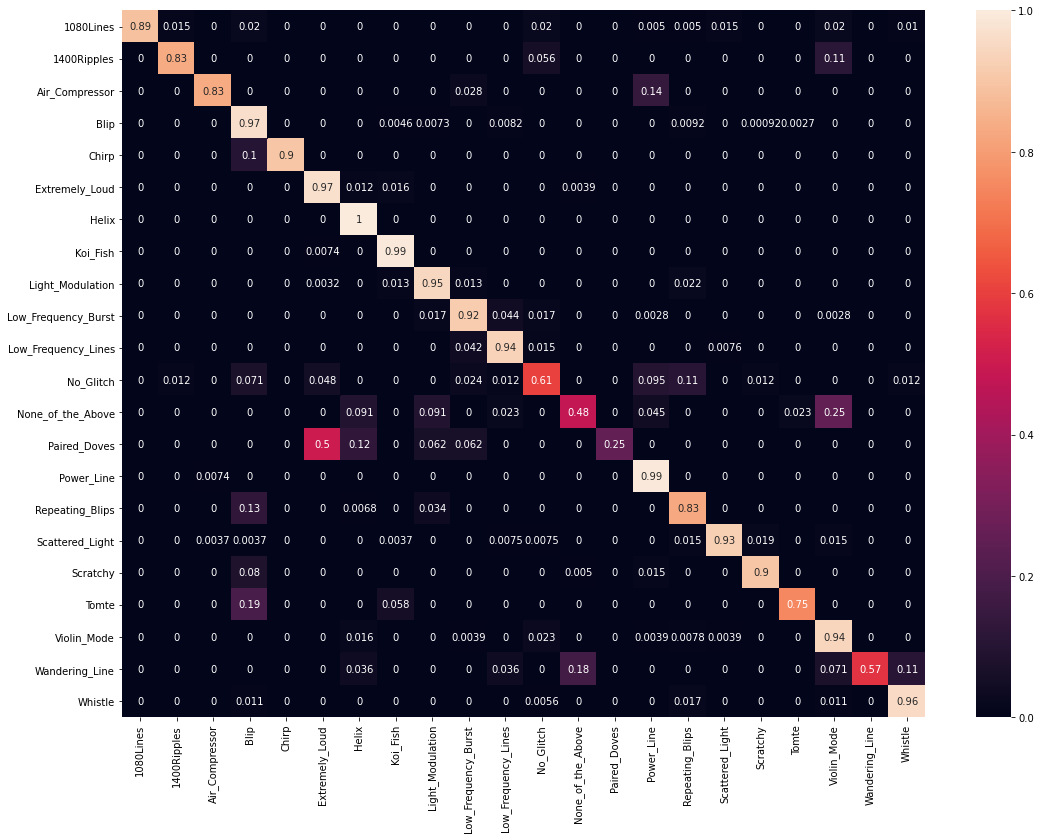

In [ ]:
from sklearn.metrics import confusion_matrix

def get_pred(matrice):
    turbo = []
    for vec in Y:
        turbo.append(np.argmax(vec))
    return turbo

y_true = data_test.classes
y_pred = get_pred(Y)

cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')


fig, ax = plt.subplots(figsize=(18,13))
sns.heatmap(cf_matrix, annot=True, ax=ax, xticklabels=data_test.class_indices ,yticklabels=data_test.class_indices)

At the end the metrics for each class!

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=data_test.class_indices))

                     precision    recall  f1-score   support

          1080Lines       1.00      0.89      0.94       200
        1400Ripples       0.88      0.83      0.86        36
     Air_Compressor       0.91      0.83      0.87        36
               Blip       0.94      0.97      0.96      1092
              Chirp       1.00      0.90      0.95        40
     Extremely_Loud       0.94      0.97      0.95       256
              Helix       0.92      1.00      0.96       168
           Koi_Fish       0.96      0.99      0.98       408
   Light_Modulation       0.93      0.95      0.94       312
Low_Frequency_Burst       0.94      0.92      0.93       360
Low_Frequency_Lines       0.89      0.94      0.91       264
          No_Glitch       0.67      0.61      0.64        84
  None_of_the_Above       0.75      0.48      0.58        44
       Paired_Doves       1.00      0.25      0.40        16
         Power_Line       0.93      0.99      0.96       272
    Repeating_Blips    

### 7) Feature extractor

I'm gonna use the previous models to build a feature extractor model F that maps each glitch into a 128 dim vector. In this way I'm able to study the intrinsic features of each type of glitch.


In [ ]:
# import other useful libraries

import os
from torch.utils.data import Dataset
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array 
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
model_extractor = Model(inputs = model.inputs, outputs = model.layers[-4].output)
model_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 300, 300, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 300, 300, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

Now we have the feature extractor model. Now I need some data to train the clustering algoirthms. I'm gonna use the validation dataset.

In [ ]:
"""function that extract the features 
  vectors 128d on a dataset.
"""

def extract_features(model, data_root, dim, sample):

    lista = []
    labels = []

    for class_name in os.listdir(data_root):

        class_folder = os.path.join(data_root, class_name)
        
        i=0

        for img_name in os.listdir(class_folder):

            img_path = os.path.join(class_folder, img_name)
                    
            img = load_img(img_path, target_size=(300, 300))
                
            img_data= np.array(img)
            img_data = img_data.reshape(1,300,300,3)
            
            img_data = preprocess_input(img_data)
            
            feat = model.predict(img_data)

            #print(np.reshape(feat,(64)))
            if i>sample:    # control the number of images per classes
              break

            lista.append(list(np.reshape(feat,(dim))))
            labels.append(class_name)
            i+=1


    #df.to_csv("/content/gdrive/MyDrive/BigData_project/dataframe.csv")
    return lista, labels

In [ ]:
#delete comment for re-run
#lista, labels = extract_features(model_extractor, "/content/gdrive/MyDrive/BigData_project/validation/validation/",128, 180)

In [ ]:
#delete all comment for re-run
#df = pd.DataFrame(lista)
#df.to_csv('/content/gdrive/MyDrive/BigData_project/input.csv', index=True)


#df_labels = pd.DataFrame(labels)
#df_labels.to_csv('/content/gdrive/MyDrive/BigData_project/labels.csv', index=True)

In the dataframe we have the feature vector ( 128 d ) for each glitch sample. We saved them in order to avoid the high computation every single run.
Now it's time for **Spark**. This framework it's gonna be used for the computation of **clustering**.

In [ ]:
sqlContext = SQLContext(sc)

#load the dataframe
df = sqlContext.read.csv('/content/gdrive/MyDrive/BigData_project/input.csv', header = True, inferSchema=True)
df_labels = sqlContext.read.csv('/content/gdrive/MyDrive/BigData_project/labels.csv', header=True)

In [ ]:
from pyspark.sql.functions import when, col

col_feature = [ str(x) for x in range(128) ]

for c in df.columns:
    if c in col_feature:
        df = df.withColumn(c,df[c].cast('double'))

for c in df.columns:
    if c in col_feature:
        df = df.withColumn(c, when(col(c)==0, 0.00000001).otherwise(col(c)))

df.show()

+---+------+------------------+------------------+-------------------+------+------------------+------------------+------+------------------+------------------+-------------------+-------------------+------+------------------+-------------------+------------------+------------------+-------------------+------+-------------------+--------------------+------+------------------+-----------------+------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------+------+-------------------+-------------------+-------------------+-------------------+------+-------------------+-------------------+------------------+------+-------------------+------------------+-------------------+-------------------+------------------+------+------------------+------+-------------------+------+-------------------+-------------------+-

In [ ]:
#join
vecAssembler = VectorAssembler(inputCols=col_feature, outputCol="features")
df_clustering = vecAssembler.transform(df).select("_c0","features")

#print the first 5 rows
df_clustering.show(n=5, truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We're ready to perfrom the clustering algorithms!!

### 8) Clustering


#### Kmeans

In [ ]:
k = 22
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_kmeans = kmeans.fit(df_clustering)
centers = model_kmeans.clusterCenters()

In [ ]:
transformed1 = model_kmeans.transform(df_clustering)
transformed = transformed1.select('_c0', 'prediction')

In [ ]:
transformed.show(n=10)

+---+----------+
|_c0|prediction|
+---+----------+
|  0|        16|
|  1|        16|
|  2|        16|
|  3|        16|
|  4|        16|
|  5|        13|
|  6|        16|
|  7|        16|
|  8|        16|
|  9|        16|
+---+----------+
only showing top 10 rows



In [ ]:
df_pred = transformed.join(df, '_c0')
df_pred.show()

+---+----------+------+------------------+------------------+-------------------+------+------------------+------------------+------+------------------+------------------+-------------------+-------------------+------+------------------+-------------------+------------------+------------------+-------------------+------+-------------------+--------------------+------+------------------+-----------------+------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------+------+-------------------+-------------------+-------------------+-------------------+------+-------------------+-------------------+------------------+------+-------------------+------------------+-------------------+-------------------+------------------+------+------------------+------+-------------------+------+-------------------+----------

ok now we can store the results.

In [ ]:
pddf_pred_kmeans = df_pred.toPandas().set_index('_c0')
pddf_pred_kmeans.to_csv('output.csv', index=True)

We can measure the goodness of clustering approach using different metrics. Here I decided to use :

- Purity 

-  Silhouette score.

##### Purity : 

In [ ]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [ ]:
labels = df_labels.select("0").toPandas()
labels = np.reshape(np.array(labels), (len(labels)))

preds_kmeans = np.asarray(pddf_pred_kmeans["prediction"])
labels_kmeans=preds_kmeans

print(purity_score(preds_kmeans,labels))

0.6438022284122563


##### Silhouette score : 

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(transformed1)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.3174423239326627


Thus using Kmeans algorithm we obtain a 0.643 purity and 0.317 Silhouette score.

Now it's the turn of GMM. I'm gonna apply a Gaussian Mixture Model. Here I use the implementation on sklearn.. there's something that go wrong with pyspark.. the predictions says that all the data belongs to the same class ._.

#### Guassian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


df_pd = df.select([c for c in df.columns if c not in {"_c0"}]).toPandas()
lista = np.array(df_pd, dtype=float)


gmm = GaussianMixture(n_components=22, random_state=2)
labels_gmm = gmm.fit(np.array(lista)).predict(np.array(lista))

##### Purity

In [ ]:
print(purity_score(labels,labels_gmm))

0.6678272980501393


##### Silhouette score

In [ ]:
evaluator2 = ClusteringEvaluator()
sil = silhouette_score(np.array(lista), labels_gmm, )
print(sil)

0.1942772221954104


### 9) Visualize the data

Now we are ready to see how the Kmeans algorithm cluster the data. However we need another tool which allows us to see the data. Our data lives on a 128d vector space, so we need an algorithm that guarantee us to map our data into a 3d space trying to avoid losses of information. 

One of the best algorithm to do that is t-SNE algorithm. It was develop exactly for this purpose.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#load the data validation to visaulize
feat = np.array(lista)
labels = list(labels)


#critic calsses
no_glitch = labels.index("No_Glitch")
none_of_the_above = labels.index("None_of_the_Above")
print(feat.shape)
print(no_glitch)
print(none_of_the_above)

(2872, 128)
1555
1643


There are some tool that allow to reduce the dimension of the data. T-SNE algorithms was develop for the purpose of visualization. Another approach is P.C.A. 

In [ ]:
X_embedded3d = TSNE(n_components=3, perplexity=30, learning_rate=100, n_iter = 1200 ).fit_transform(feat)
print(X_embedded3d.shape)

(2872, 3)


In [ ]:
X_embedded_pca3d = PCA(n_components=3).fit_transform(feat)
print(X_embedded_pca3d.shape)

(2872, 3)


Visualize in 3d with the predicted target!

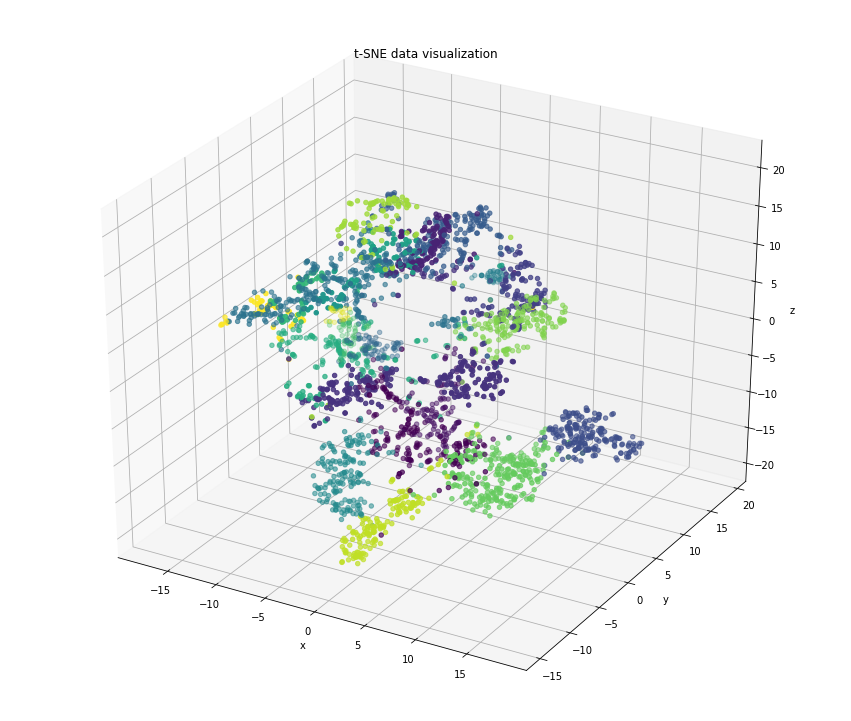

In [ ]:
ax3d = plt.figure(figsize=(15,13)).gca(projection='3d')
ax3d.scatter(X_embedded3d[:,0], X_embedded3d[:,1], X_embedded3d[:,2], c=pddf_pred_kmeans.prediction)
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')
ax3d.set_title("t-SNE data visualization")
plt.show()

Let's visualize a subset of the data points!!

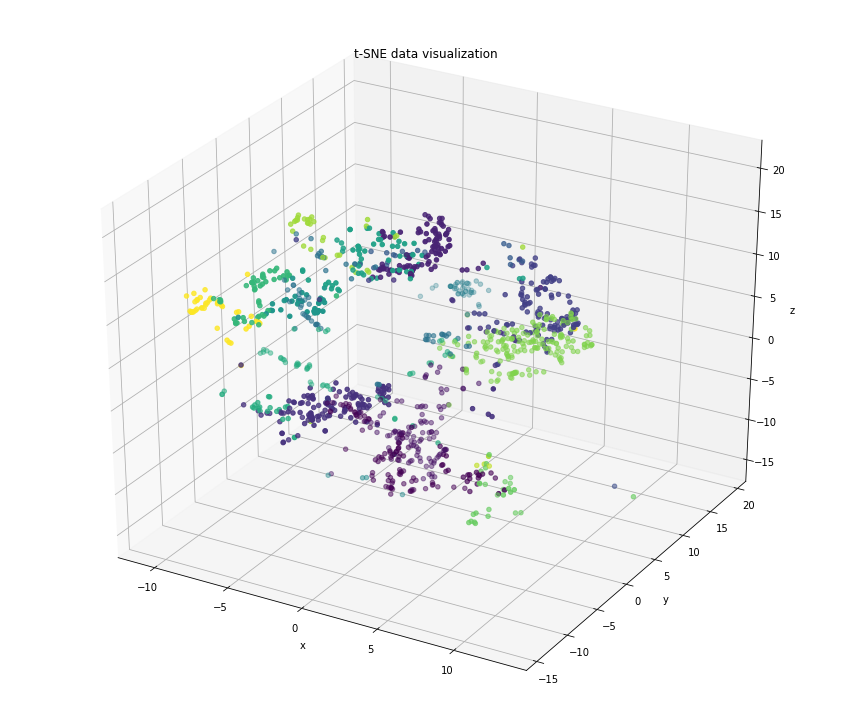

In [ ]:
ax3d = plt.figure(figsize=(15,13)).gca(projection='3d')
ax3d.scatter(X_embedded3d[500:none_of_the_above+52,0], X_embedded3d[500:none_of_the_above+52,1], X_embedded3d[500:none_of_the_above+52,2], c=pddf_pred_kmeans.prediction[500:none_of_the_above+52])
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')
ax3d.set_title("t-SNE data visualization")
plt.show()

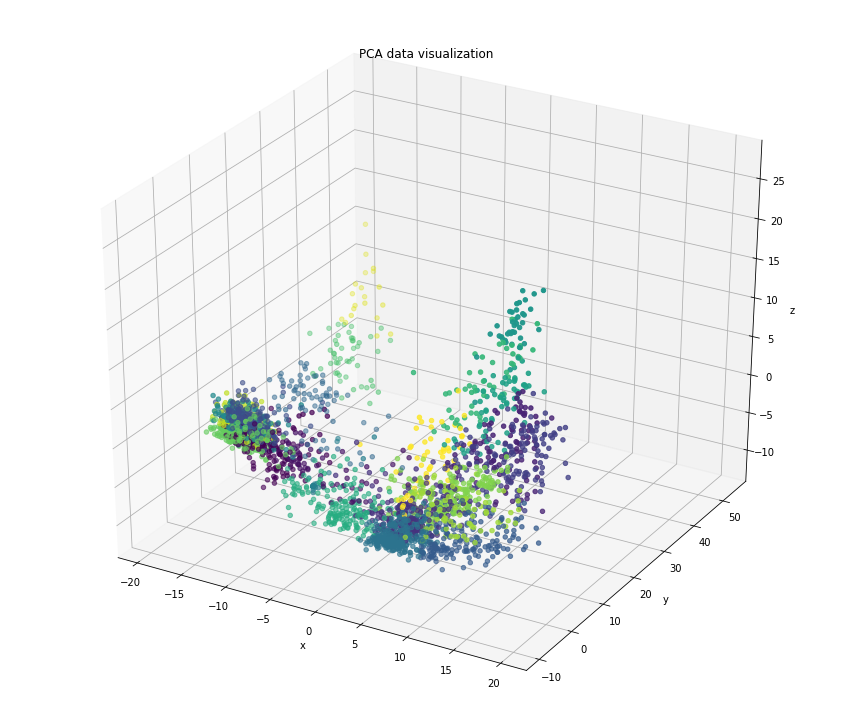

In [ ]:
ax3d = plt.figure(figsize=(15,13)).gca(projection='3d')
ax3d.scatter(X_embedded_pca3d[:,0], X_embedded_pca3d[:,1], X_embedded_pca3d[:,2], c=pddf_pred_kmeans.prediction)
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')
ax3d.set_title("PCA data visualization")
plt.show()

Let's re-run the algorithm for a 2d visualization!



In [ ]:
X_embedded2d = TSNE(n_components=2, perplexity=35, learning_rate=100, n_iter = 2000,  ).fit_transform(feat)
print(X_embedded2d.shape)

X_embedded_pca2d = PCA(n_components=2).fit_transform(feat)
print(X_embedded_pca2d.shape)

(2872, 2)
(2872, 2)


Compare t-SNE with PCA.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


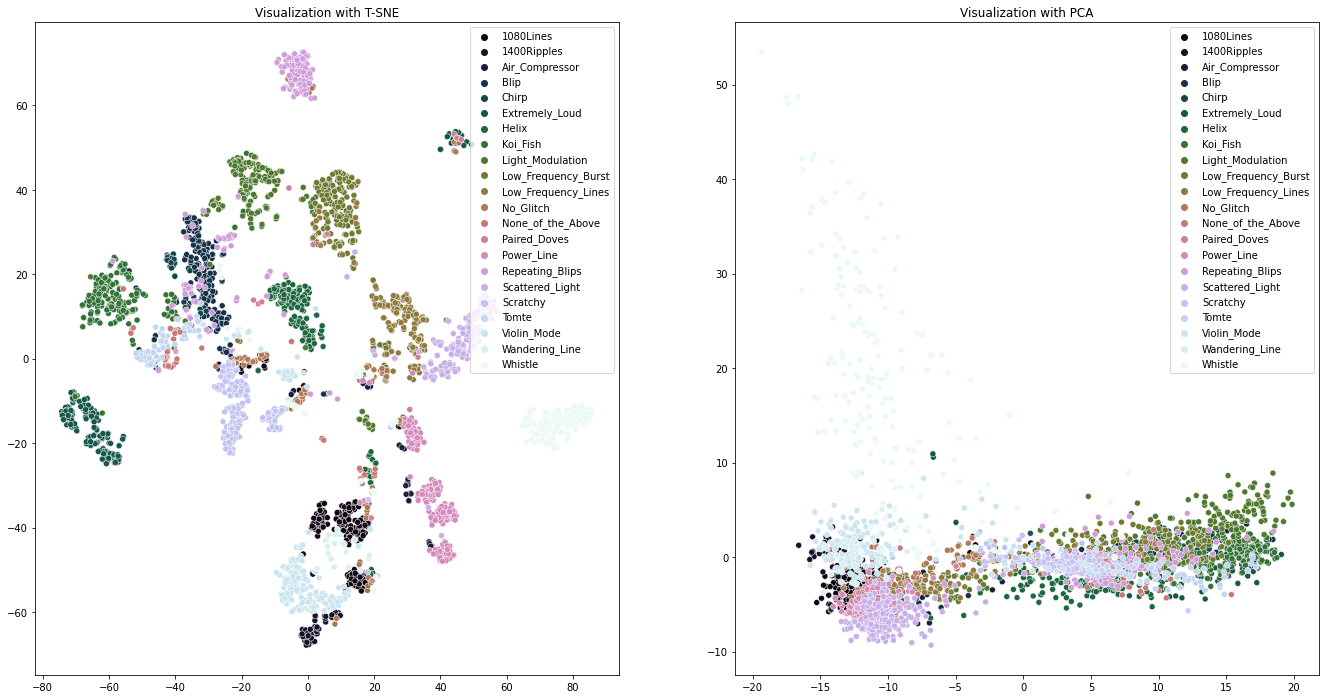

In [ ]:
fig, (ax255, ax225) = plt.subplots(1,2,figsize=(23,12))
ax255.set_title('Visualization with T-SNE')
ax225.set_title("Visualization with PCA")

sns.scatterplot(X_embedded2d[:,0], X_embedded2d[:,1],legend=True, hue=labels, palette=sns.color_palette("cubehelix", n_colors=22), ax=ax255)
sns.scatterplot(X_embedded_pca2d[:,0], X_embedded_pca2d[:,1],legend=True, hue=labels, palette=sns.color_palette("cubehelix", n_colors=22), ax=ax225)

**T-SNE works much better!!**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


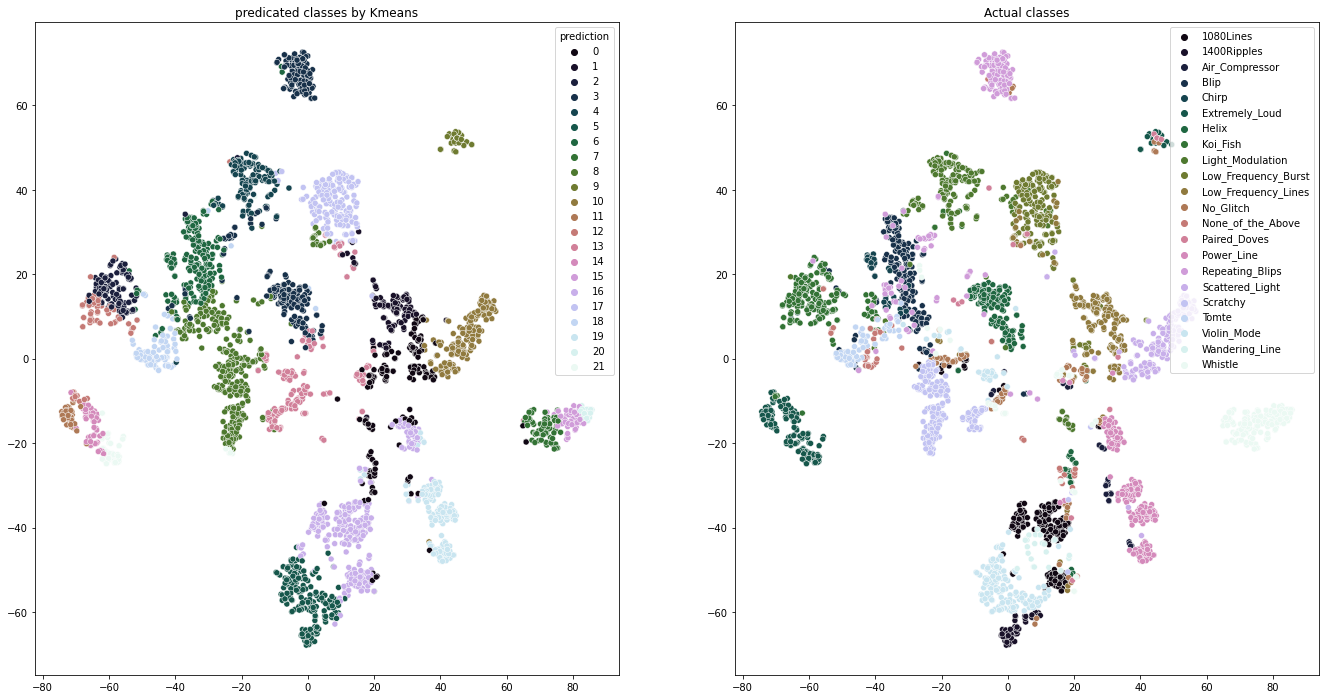

In [ ]:
fig, (ax2, ax22) = plt.subplots(1,2,figsize=(23,12))
ax2.set_title('predicated classes by Kmeans')
ax22.set_title("Actual classes")

sns.scatterplot(X_embedded2d[:,0], X_embedded2d[:,1],legend=True, hue=pddf_pred_kmeans.prediction, palette=sns.color_palette("cubehelix", n_colors=22), ax=ax2)
sns.scatterplot(X_embedded2d[:,0], X_embedded2d[:,1],legend=True, hue=labels, palette=sns.color_palette("cubehelix", n_colors=22), ax=ax22)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


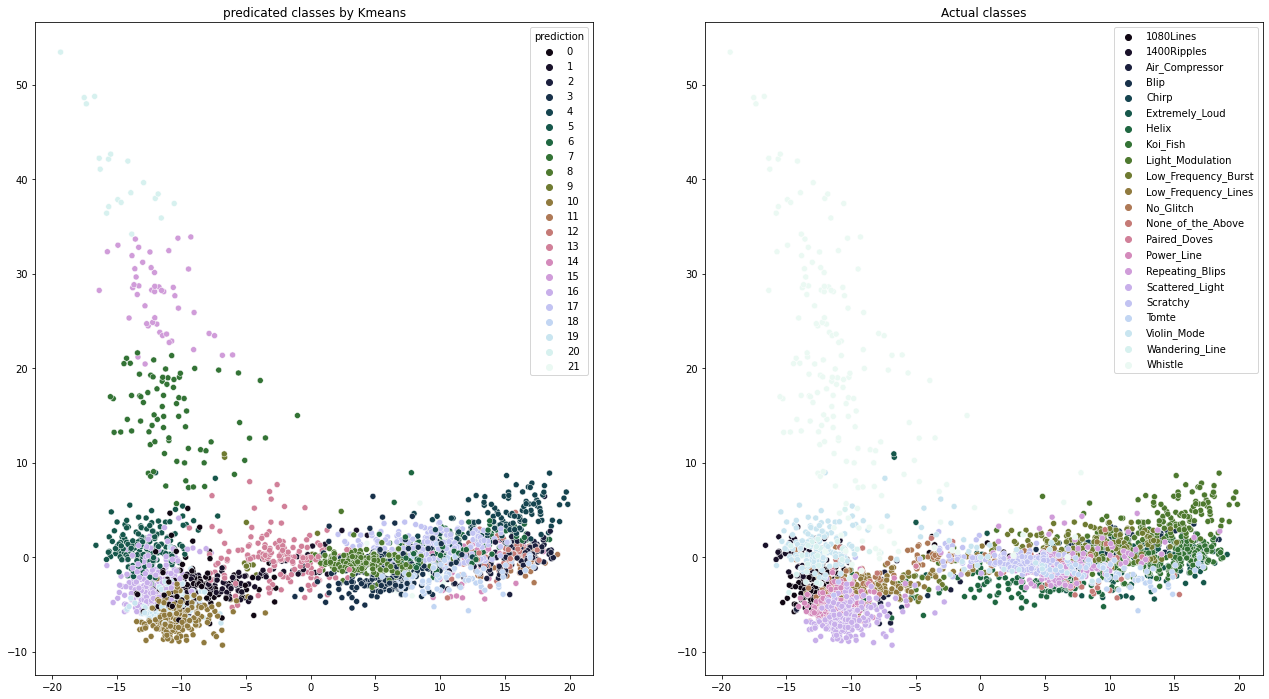

In [ ]:
fig, (ax223, ax224) = plt.subplots(1,2,figsize=(22,12))
ax223.set_title('predicated classes by Kmeans')
ax224.set_title("Actual classes")

sns.scatterplot(X_embedded_pca2d[:,0], X_embedded_pca2d[:,1],legend=True, hue=pddf_pred_kmeans.prediction, palette=sns.color_palette("cubehelix", n_colors=22), ax=ax223)
sns.scatterplot(X_embedded_pca2d[:,0], X_embedded_pca2d[:,1],legend=True, hue=labels, palette=sns.color_palette("cubehelix", n_colors=22), ax=ax224)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


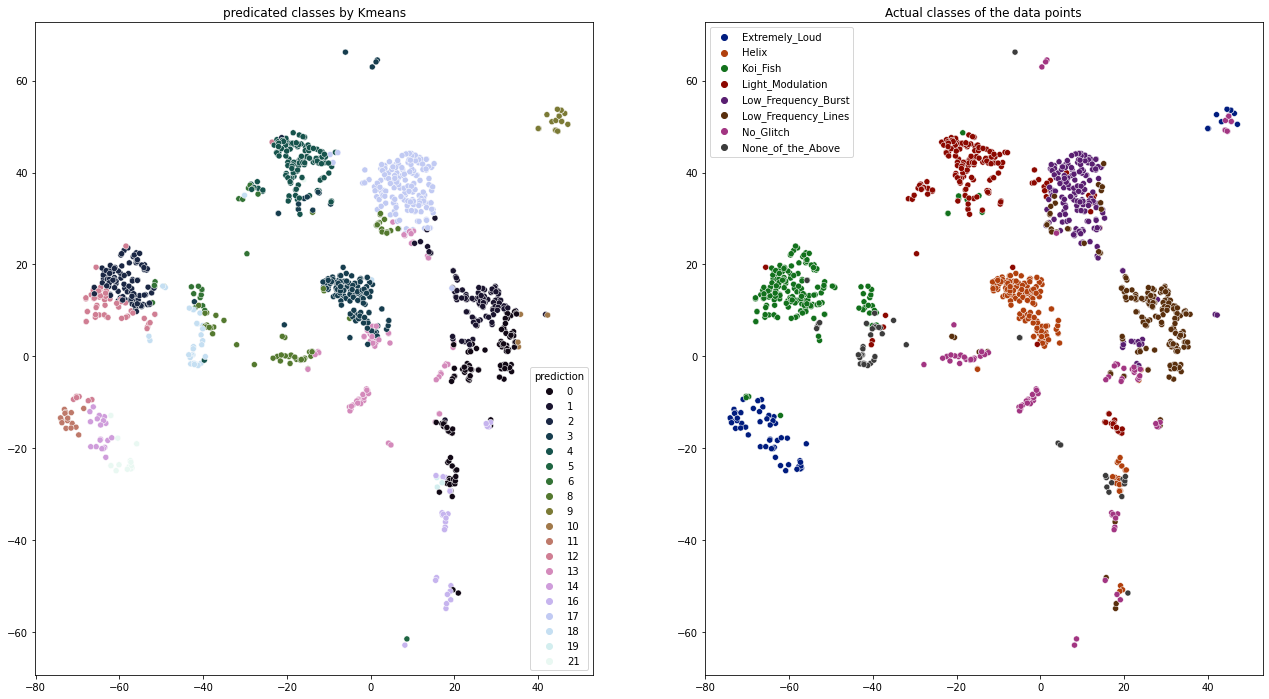

In [ ]:
fig, (ax4, ax42) = plt.subplots(1,2,figsize=(22,12))
ax4.set_title('predicated classes by Kmeans')
ax42.set_title("Actual classes of the data points")

sns.scatterplot(X_embedded2d[600:none_of_the_above+52,0], X_embedded2d[600:none_of_the_above+52,1],
                legend=True,hue=pddf_pred_kmeans.prediction[600:none_of_the_above+52], palette=sns.color_palette("cubehelix", n_colors = 19), ax=ax4)
sns.scatterplot(X_embedded2d[600:none_of_the_above+52,0], X_embedded2d[600:none_of_the_above+52,1],
                legend=True,hue=labels[600:none_of_the_above+52], palette=sns.color_palette("dark",n_colors=8), ax=ax42)

**Very intersting... we can see the clustsers better.. t-SNE works well !!** 

It seems that some classes are correct. T-SNE works better w.r.t PCA. The reason might be the fact that t-SNE is a non-linear algorithm.

### 10) Final considerations and final check

In summary, we developed 3 deep learning models (using transfer learning) to predict the 22 glitch classes contained in the dataset. These models get good results, about 92% (almost all models) accuracy on the test set at our disposal. In the datasets there are actually 21 classes (certified) (one of which is No Glitch). There's a generic class that contains a series of samples that are definitely not known glitch types. Despite these performances, however, we want something more ... we still have several things to manage:

- Accuracy as high as it is, we would like Recall and Precision high on all classes especially for the No_glitch class.

- We would like to have models that could help us discover new types of glitches never observed so far and that can be used in conjunction with the previous deep learning models.

To solve the first point directly, more computing power and a more in-depth study would be needed to produce more advanced neural network models, even more advanced than simple and good transfer learning and fine tuning technique.

For the second case, I implemented clustering algorithms, i.e. using an unsupervised machine learning approach for classifying glitches. To do this, however, I used the deep learning model ( the best one ) previously developed as Feature Extractor ( Dim. Reduction )  by mapping each glitch into a 128d feature vector and applying 2 types of clustering algorithms:

- Kmeans
- GMM

In this application, it would be essentail to visualize the cluster. Therefore for visualizing data I used a non-linear dimensionality reduction algorithm ( t-SNE ) and I compared it with a linear algorithm PCA.

Now let's go see the last phase. How will the glitches of the "None of the above" class be grouped?

One thing to say is that we are not interested in the clustering label, but rather which samples will be clustered together. Ideally we would like glitches of the same type to be grouped in the same class (it doesn't matter which one, but in the same one).

Let's check how the glitches of the None_of_the_Above class are grouped.

In [ ]:
# take the predictions of the None of the above samples.
# 52 samples of None of the above

labels_critic_gmm = labels_gmm[none_of_the_above:none_of_the_above+52]
labels_critic_kmeans = labels_kmeans[none_of_the_above : none_of_the_above+52]
print(labels_critic_gmm)
print(labels_critic_kmeans)

[19 16 19 19  5 16  2  2  2  5  6 11  6  6  1  2 19 19 11  0 17  2 11  0
 16 16 17 19  1  5  5  2 11 19 11  2  5 11 11  0 19 11  2  5 20 19 19 11
  5 19 19 19]
[18 12 18 18 16 12 18 18 18  0  3  8 13 21 13  3 18 18  8 19  0 12  8 19
  2  2  0 18 13  0  0 18  8 18  8  4 19  8  8  0 18  8 18  0 12 18 18 18
 16 18 18 18]


In [ ]:
def plot_classes_unknown(data_root, labels_critic, c, model_name, class_analyze):

    fig = plt.figure(figsize=(14, 14))
    rows = 8
    columns = 7
    
    fig.suptitle( class_analyze + " samples which were predicted by the " + model_name +  " as class " + str(c))
    labels_critic2 = np.array(labels_critic)

    for class_name in os.listdir(data_root):

        class_folder = os.path.join(data_root, class_name)
        
        i=0
        j=0
        
        if class_name==class_analyze:

            for img_name in os.listdir(class_folder):

                img_path = os.path.join(class_folder, img_name)
                            
                img = load_img(img_path, target_size=(300, 300))
                
                if  ([labels_critic2 == c][0])[i] == True:

                    fig.add_subplot(rows, columns,j+1 )
          
                    # showing image
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title("class " + str(c))
                    j+=1
                i+=1

#### KMeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


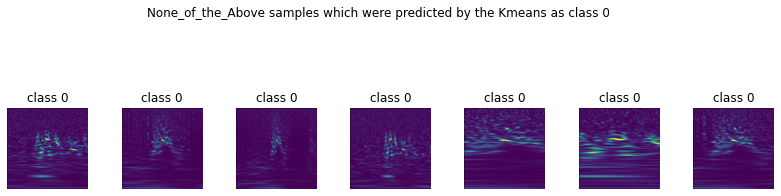

<Figure size 1008x1008 with 0 Axes>

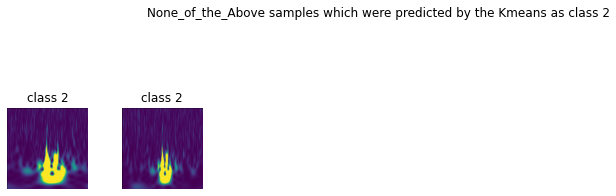

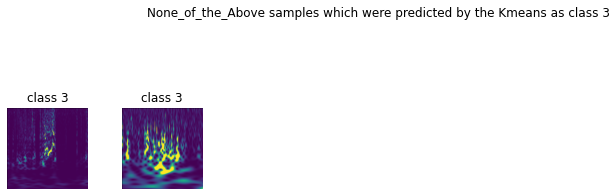

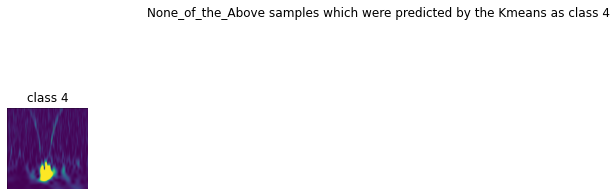

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

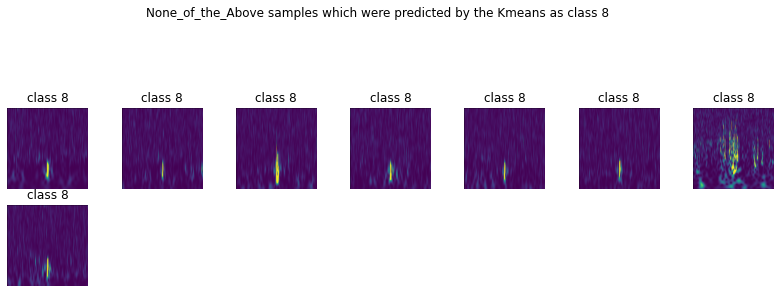

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

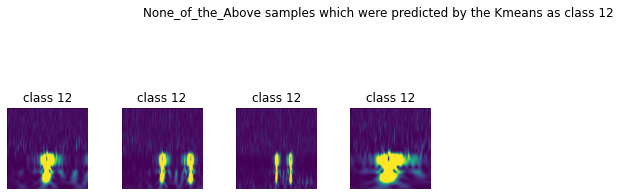

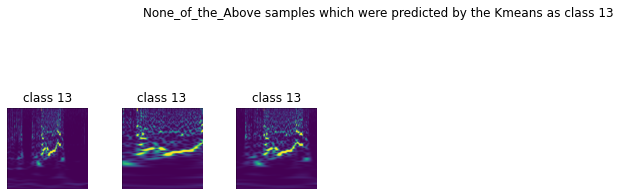

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

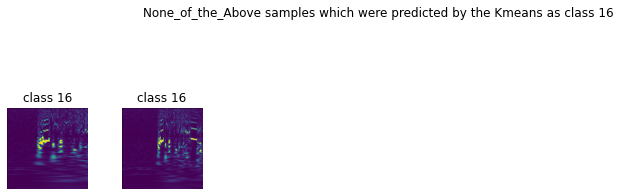

<Figure size 1008x1008 with 0 Axes>

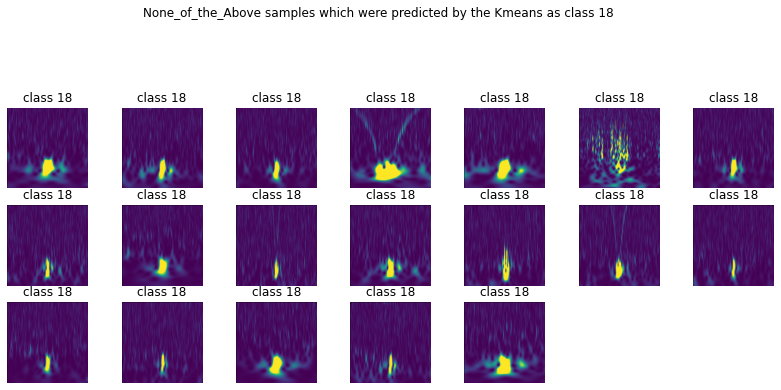

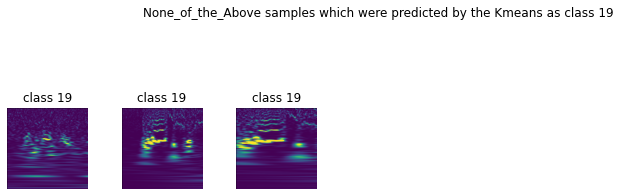

<Figure size 1008x1008 with 0 Axes>

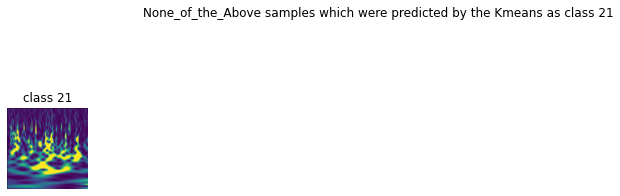

In [ ]:
root = "/content/gdrive/MyDrive/BigData_project/validation/validation"

for x in range(22):
  plot_classes_unknown(root, labels_critic_kmeans, x, "Kmeans", "None_of_the_Above")

#### Guassian Mixture Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


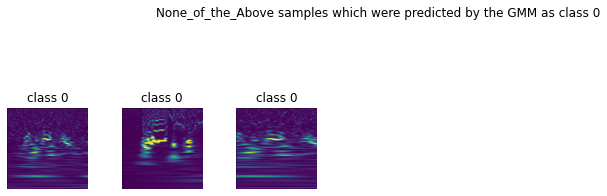

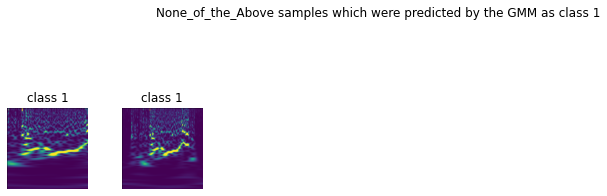

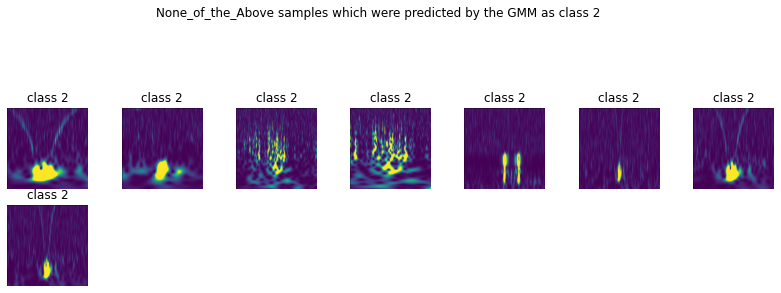

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

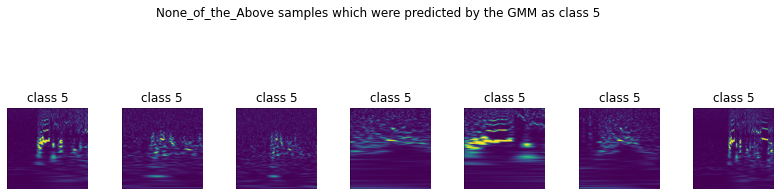

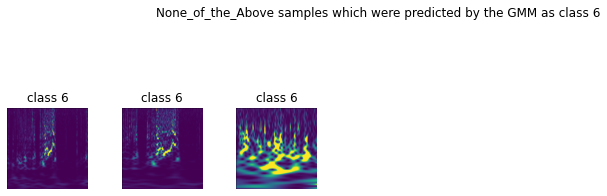

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

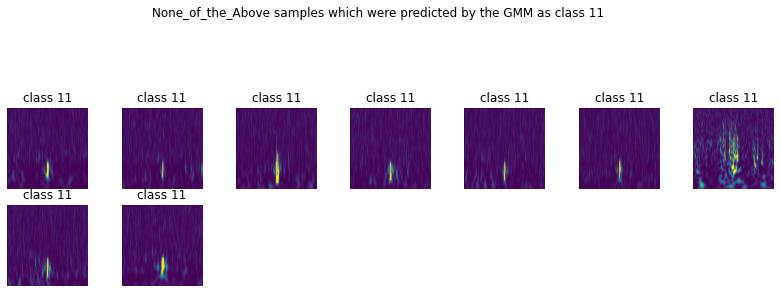

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

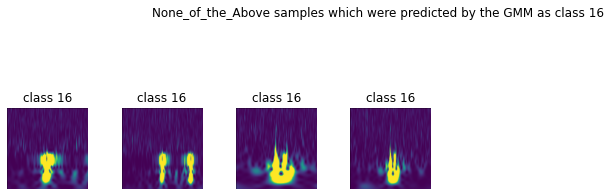

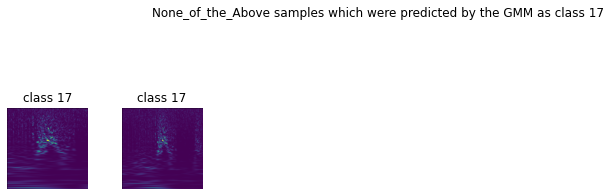

<Figure size 1008x1008 with 0 Axes>

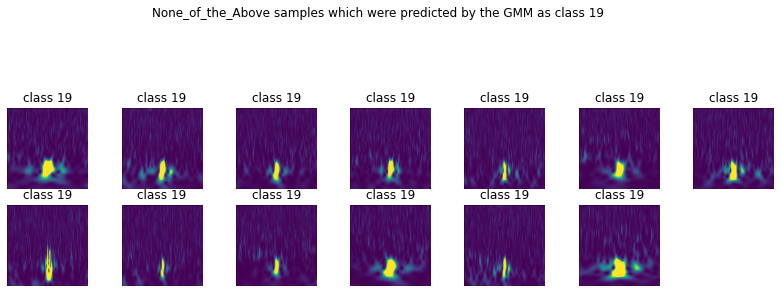

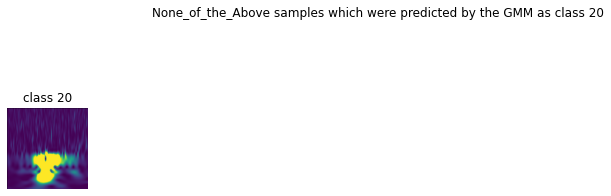

<Figure size 1008x1008 with 0 Axes>

In [ ]:
root = "/content/gdrive/MyDrive/BigData_project/validation/validation"

for x in range(22):
  plot_classes_unknown(root, labels_critic_gmm, x, "GMM", "None_of_the_Above")

#### Final check

We saw how clustering approach could be useful for humans in the gravity spy pipeline. But we need to do another test. If we have a set of glitches all of the same class what would be the prediction? Let's take the class "Tomte".

In [ ]:
chirp_index = list(labels).index("Tomte")
print(chirp_index)
labels_critic_gmm2 = labels_gmm[chirp_index:chirp_index+68]
labels_critic_kmeans2 = labels_kmeans[chirp_index:chirp_index+68]
print(labels_critic_gmm2)
print(labels_critic_kmeans2)

2418
[19 11 11 19 11 19 19 19 19 11 19 19 12 11 11 19 19 11 11 19 19 19 19 11
 19 19 19 11 19 19 19 19 19 11  2 19 11 12 19 19 19 19 11 19 19 19 11 19
 19 19 19 19 19 19 19 11 11 11 12 11 19 11 19 19 11 11 19 11]
[18  8  8 18 18 18 18 18 18  6 18 18  6  8  8 18 18  8  8 18 18 18 18 18
 18 18 18  8 18 18 18 18 18  8 18 18  8  6 18 18 18 18  8 18 18 18 18 18
 18 18 18 18 18 18 18  8 18  8  6  8 18  8 18 18  6  8 18  8]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

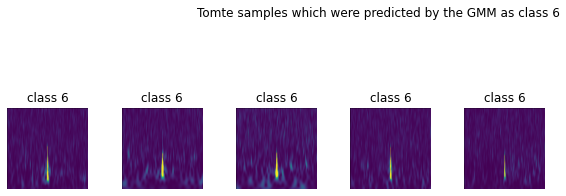

<Figure size 1008x1008 with 0 Axes>

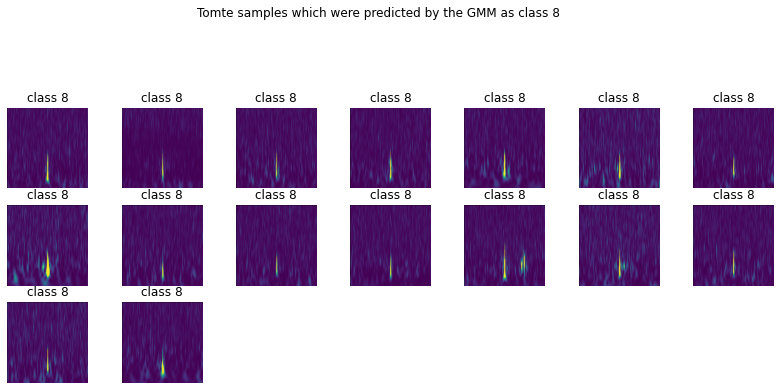

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

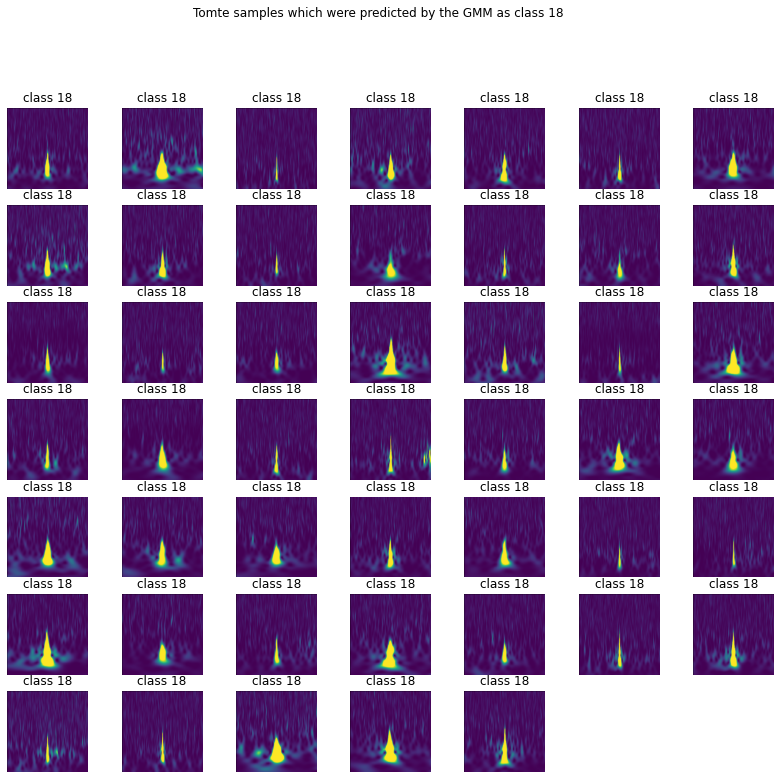

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

In [ ]:
oot = "/content/gdrive/MyDrive/BigData_project/validation/validation"
for x in range(22):

  plot_classes_unknown(root, labels_critic_kmeans2, x, "GMM", "Tomte")